# **Pontificia Universidad Javeriana**
###Daniel Andrés Pineda Suárez
#**Inteligencia artificial**
###Tarea Titanic
###Noviembre 2021

***Adecuación de los datos***

Inicialmente, para realizar la selección más adecuada de un clasificador, fue necesario plantear una sucesión ordenada de pasos dentro de un procedimiento.
1.	Como primera medida, las edades que aparecían como valores nulos, fueron intercambiadas por la media de todas las edades.
2.	Posteriormente, la columna de “Cabina”, fue eliminada debido a que no fue considerada para el modelo.
3.	Luego fueron cambiados los caracteres correspondientes al sexo por valores binarios, de tal manera que: hombres=1, mujeres=0.
4.	Seguidamente, se llenaron los espacios vacíos de la columna de “Embarcado” y ”Tarifa”, por la moda y la mediana, respectivamente.
5.	Inmediatamente después, fueron cambiados los valores C, Q y S de la columna de embarcado, por 0, 1 y 2, respectivamente.
6.	Luego se verifica si hay valores nulos.


In [197]:

from google.colab import drive 
drive.mount('/content/gdrive')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from subprocess import check_output
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')
titanic_train=pd.read_csv("/content/gdrive/MyDrive/IA Datasets/train.csv", sep=',',header=0)
titanic_test=pd.read_csv("/content/gdrive/MyDrive/IA Datasets/test.csv", sep=',',header=0)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###**Implementar el mejor clasificador de los vistos en clase.**

####Adecuación de los datos

In [198]:
titanic_train.loc[titanic_train.Age.isnull(), 'Age'] = titanic_train.groupby('Pclass')['Age'].transform('mean')
titanic_test.loc[titanic_test.Age.isnull(), 'Age'] = titanic_test.groupby('Pclass')['Age'].transform('mean')

titanic_train = titanic_train.drop('Cabin', axis=1)
titanic_test = titanic_test.drop('Cabin', axis=1)

titanic_train['Sex'] = titanic_train['Sex'].map({'male':1,'female':0,},na_action=None)
titanic_test['Sex'] = titanic_test['Sex'].map({'male':1,'female':0,},na_action=None)

titanic_train['Embarked'].fillna(titanic_train['Embarked'].mode()[0], inplace=True)
titanic_test['Fare'].fillna(titanic_test['Fare'].median(), inplace = True)

titanic_test['Embarked'] = titanic_test['Embarked'].map({'C':0,'Q':1,'S':2,np.nan:0},na_action=None)
titanic_train['Embarked'] = titanic_train['Embarked'].map({'C':0,'Q':1,'S':2,np.nan:0},na_action=None)

print('Training Data Null Values')
print(titanic_train.isnull().sum())
print("-" * 30)
print('Test Data Null Values')
print(titanic_test.isnull().sum())

Training Data Null Values
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
------------------------------
Test Data Null Values
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [199]:
from sklearn.metrics import confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score  
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,roc_auc_score

X = titanic_train[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].values ##Fueron tomados estos 7 parámetros para la evaluación de los clasificadores
y = titanic_train['Survived'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

results = pd.DataFrame(columns=['Validation'], index=['Logistic Regression', 'Support Vector Machine', 'KNN'])

###Regresión Logistica

In [200]:
def log_reg(X_train, X_test, y_train, y_test):
    logmodel = LogisticRegression(C=.01)
    logmodel.fit(X_train, y_train)
    predictions = logmodel.predict(X_test)
    y_test_scores = logmodel.predict_proba(X_test)
    
    MCC = matthews_corrcoef(y_test, predictions)
    print("matthews_corrcoef", MCC)
    ACC = accuracy_score(y_test, predictions)
    print("Accuracy", ACC)


    fpr,tpr,thresholds = roc_curve(y_test, y_test_scores[:,1])
    roc_auc=roc_auc_score(y_test, y_test_scores[:,1])
    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, color='red',lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Característica Operativa del Receptor. ROC')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy_score(y_test, predictions)
      

matthews_corrcoef 0.36411904057042216
Accuracy 0.6977611940298507


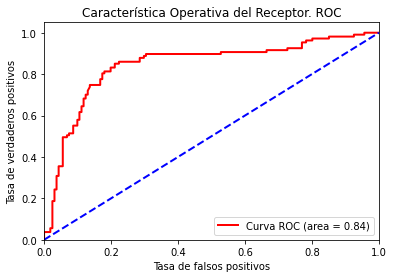

In [201]:

LR_preds = log_reg(X_train, X_test, y_train, y_test)


results.loc['Logistic Regression', 'Validation'] = LR_preds

Se puede determinar un coeficiente Mattews bastante bajo (de 0.36), sumado a una precisión menor a 0.7 por lo que es un clasificador descartado en un primer momento. Esperando que alguno de los dos restantes, presente un comportamiento mejor

###K vecinos más próximos

In [202]:
def KNN(X_train, X_test, y_train, y_test):
    
    #escalizacion
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    ks = [i + 1 for i in range(20)]
    accuracy = [0 for i in range(20)]
    

    for i, k in enumerate(ks):
        kn = KNeighborsClassifier(n_neighbors = k)
        kn.fit(X_train, y_train)
        predictions = kn.predict(X_test)
        y_test_scores = kn.predict_proba(X_test)
        accuracy[i] = accuracy_score(y_test, predictions)
        mcc=(matthews_corrcoef(y_test, predictions))
        f1=(f1_score(y_test, predictions, average='macro'))

      
    print("matthews_corrcoef", mcc)
    print("Accuracy", accuracy)


    fpr,tpr,thresholds = roc_curve(y_test, y_test_scores[:,1])
    roc_auc=roc_auc_score(y_test, y_test_scores[:,1])
    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, color='red',lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Característica Operativa del Receptor. ROC')
    plt.legend(loc="lower right")
    plt.show()
    
       
    return max(accuracy)

matthews_corrcoef 0.5412745491016266
Accuracy [0.753731343283582, 0.7798507462686567, 0.8208955223880597, 0.8097014925373134, 0.8059701492537313, 0.8208955223880597, 0.8134328358208955, 0.8134328358208955, 0.7873134328358209, 0.7985074626865671, 0.7910447761194029, 0.8059701492537313, 0.7947761194029851, 0.8022388059701493, 0.7947761194029851, 0.7947761194029851, 0.8022388059701493, 0.7947761194029851, 0.7910447761194029, 0.7835820895522388]


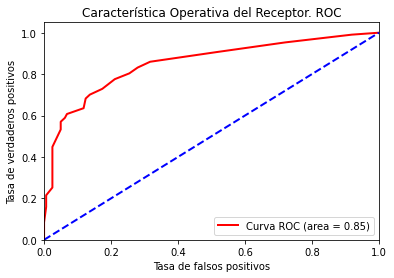

,Validation
Logistic Regression,0.697761
Support Vector Machine,NaN
KNN,0.820896


In [203]:
knn_preds = KNN(X_train, X_test, y_train, y_test)
results.loc['KNN', 'Validation'] = knn_preds
results.head()


Como se puede observar, la precisión más alta de momento, corresponde a KNN. Adicionalmente, es notable que el valor de área de la curva ROC es ligeramente mayor al correspondiente a la regresión logística. 

###Support Vector Machine

In [204]:
def SVM(X_train, X_test, y_train, y_test):
    
    #escalizacion
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    

    c_vals = list(range(1, 100))

    accuracy = [0 for i in range(99)]
    
    for i, c in enumerate(c_vals):
        svc_model = SVC(C=c, probability=True)
        svc_model.fit(X_train, y_train)
        predictions = svc_model.predict(X_test)
        y_test_scores = svc_model.predict_proba(X_test)
        accuracy[i] = accuracy_score(y_test, predictions)
        mcc=(matthews_corrcoef(y_test, predictions))
        f1=(f1_score(y_test, predictions, average='macro'))


    print("matthews_corrcoef", mcc)
    print("Accuracy", accuracy)


    fpr,tpr,thresholds = roc_curve(y_test, y_test_scores[:,1])
    roc_auc=roc_auc_score(y_test, y_test_scores[:,1])
    plt.figure()
    lw = 2

    plt.plot(fpr, tpr, color='red',lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Característica Operativa del Receptor. ROC')
    plt.legend(loc="lower right")
    plt.show()

    return max(accuracy)

matthews_corrcoef 0.5899412986144098
Accuracy [0.8059701492537313, 0.7947761194029851, 0.7985074626865671, 0.8059701492537313, 0.8022388059701493, 0.8022388059701493, 0.8022388059701493, 0.8022388059701493, 0.7947761194029851, 0.7985074626865671, 0.7947761194029851, 0.7873134328358209, 0.7873134328358209, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7873134328358209, 0.7873134328358209, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7910447761194029, 0.7910447761194029, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7873134328358209, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.7910447761194029, 0.79104477611

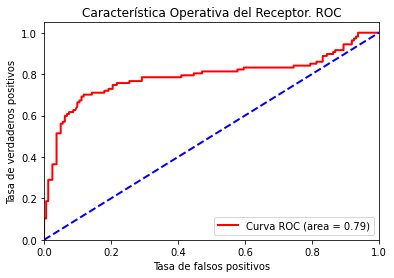

,Validation
Logistic Regression,0.697761
Support Vector Machine,0.80597
KNN,0.820896


In [205]:
svm_preds = SVM(X_train, X_test, y_train, y_test)


results.loc['Support Vector Machine', 'Validation'] = svm_preds
results.head()

De acuerdo a la validación final, se mantiene el supuesto que previamente se estableció. Teniendo que el clasificador KNN es el más preciso, acorde a los parámetros obtenidos de Curva ROC y _validación_.

###Test final

In [206]:
x_final_titanic = titanic_test[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']].values
scaler= StandardScaler()
scaler.fit(X)
x_final_titanic = scaler.transform(x_final_titanic)
X_train = scaler.transform(X_train)
ks = [i + 1 for i in range(20)]


for i, k in enumerate(ks):
    kn = KNeighborsClassifier(n_neighbors = k)
    kn.fit(X_train, y_train)
    predictions = kn.predict(x_final_titanic)

print(predictions)

[0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


Fueron obtenidos los anteriores resultados de la predicción, en forma matricial, y por medio del modelo de clasificación seleccionado (KNN), de tal manera que 1 corresponde a los supervivientes, y 0 a los no sobrevivientes.

In [207]:
from google.colab import files
sub = pd.DataFrame({"PassengerId": titanic_test['PassengerId'],
                   "Survived": predictions})
sub.to_csv('final.csv',index = False)
files.download('final.csv')
sub.head(20)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


Al adjuntar el CSV de los resultados, para obtener la calificación de la predicción
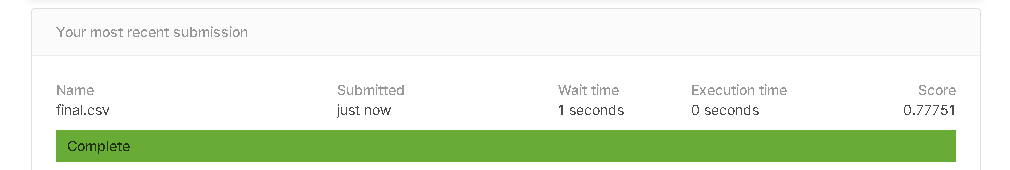

**CONCLUSIONES**

**-** En la validación de datos finales, se observa que el mejor clasificador de los vistos en clase corresponde a **KNN**, algo que se determina a partir del parámetro de precisión fundamentalmente.

**-** Al verificar la calificación, se observa un valor de "score" bastante alto. Esto, teniendo en cuenta que se realizan predicciones por medio de métodos básicos dentro de lo que involucra ***Machine Learning***. Puntaciones más altas pueden corresponder al uso de *****Deep Learning*****.

**REFERENCIAS**
-	Calderón Bocanegra, Francisco. [Francisco Carlos Calderon]. Regresión logística [Video]. Youtube. https://www.youtube.com/watch?v=1aHT2sDftYM&t=114s 
-	Calderón Bocanegra, Francisco. [Francisco Carlos Calderon]. K Vecinos Más cercanos para clasificación y regresión [Video] Youtubehttps://www.youtube.com/watch?v=HHsA2ZqIa2M&t=1303s&ab_channel=FranciscoCarlosCalderon 
